# Programmatic Entropy and Information Calculations -- Demo Notebook

## 0. Imports

In [1]:
## Set the PYTHON package path
import os, sys
package_root = os.path.abspath('../src/')
if package_root not in sys.path:
    sys.path.insert(0, package_root)

#package_root

In [2]:
## Import our data creation / prep routines
from nam_entropy.make_data import make_samples_dataframe_from_distributions
from nam_entropy.data_prep import data_df_to_pytorch_data_tensors_and_labels

## Import soft entropy calculation routines
from nam_entropy.h import *

## Import visualization routines
from nam_entropy.bin_distribution_plots import plot_tensor_bars

In [3]:
# Import SciPy distributions
from scipy import stats

## Import the Pytorch distributions
import torch

## 1. Create Sample Data

In [4]:
## Define some example SciPy distributions
dist1 = stats.norm(loc=0, scale=1)  # Standard normal
dist2 = stats.norm(loc=3, scale=1.5)  # Different normal
dist3 = stats.uniform(loc=-2, scale=4)  # Uniform distribution


In [5]:
## Get some associated sample data from these distributions
n_samples_list = [10, 20, 30]
distribution_list = [dist1, dist2, dist3]
label_list = ['A - Normal(0, 1)', 'B - Normal(3, 1.5)', 'C - Uniform on [-2, 2]']

randomized_data_df = \
    make_samples_dataframe_from_distributions(n_samples_list, distribution_list, label_list, 
                                              label_columns_name = 'label', 
                                              data_component_name_list=None, 
                                              randomize_samples = True)

In [6]:
#randomized_data_df.shape

In [7]:
#randomized_data_df

## 2. Pytorch Preparation of Sample Data

In [8]:
## Convert the data to PyTorch format
index_tensor, data_tensor, label_list, label_list_row_index_lookup_dict = \
    data_df_to_pytorch_data_tensors_and_labels(randomized_data_df)

In [9]:
#index_tensor.shape

In [10]:
#index_tensor

In [11]:
#data_tensor.shape

In [12]:
#data_tensor

In [13]:
#label_list

In [14]:
#label_list_row_index_lookup_dict

## 3. Create the associated Soft-binned Probability Distributions

### 3.1. Create the soft-binned probability distributions for each point

In [15]:
## Setup the binning parameters for euclidean space distributions
n_bins = 10
n_heads = 1 
bin_type = "uniform"
dist_fn = "euclidean"
smoothing_fn = "softmax"
smoothing_temp = 1.0

## Perform the soft-binning
tmp_scores, tmp_bins = \
    soft_bin(all_representations = data_tensor, \
             n_bins = n_bins, \
             n_heads = n_heads, \
             bin_type = bin_type, \
             dist_fn = dist_fn, \
             smoothing_fn = smoothing_fn, 
             smoothing_temp = smoothing_temp)

## Show the shape of the final probability distribution tensor -- should be [N, n_heads, n_bins]
tmp_scores.shape                                                                  

torch.Size([60, 1, 10])

In [16]:
#tmp_scores.shape

In [17]:
#data_tensor[0]

In [18]:
## Get the data tensor with no extra n_heads variable
tmp_scores__no_heads = tmp_scores.squeeze(1)
tmp_scores__no_heads.shape

torch.Size([60, 10])

### 3.2. Create the probability distribution for the total population (all labels together)

In [19]:
## Compute the sum of all soft-binned probability distibutions
prob_dist_sum_tensor = tmp_scores__no_heads.sum(0)

In [20]:
prob_dist_sum_tensor.shape

torch.Size([10])

In [21]:
## Compute the total population probability vector
prob_dist_for_total_population_tensor = prob_dist_sum_tensor / tmp_scores__no_heads.shape[0]

In [22]:
## Check that this is a probability vector
prob_dist_for_total_population_tensor.sum()

tensor(1., dtype=torch.float64)

In [23]:
## Check its shape
prob_dist_for_total_population_tensor.shape

torch.Size([10])

In [24]:
## Check its values
prob_dist_for_total_population_tensor

tensor([0.0795, 0.0751, 0.0880, 0.1100, 0.0754, 0.0750, 0.0771, 0.1458, 0.1388,
        0.1353], dtype=torch.float64)

### 3.3. Create the probability distributions for each population label

In [25]:
## Prepare to compute the index sum
num_samples = index_tensor.shape[0]  ## also data_tensor.shape[0]
n_bins = tmp_scores.shape[-1]  ## prob_dist_num_of_points
num_labels = len(label_list)

## Get the data tensor with no extra n_heads variable
tmp_scores__no_heads = tmp_scores.squeeze(1)

## Compute the sum of the soft-binned probability distributions for each label
label_prob_dist_sum_tensor = torch.zeros(num_labels, n_bins, dtype = tmp_scores__no_heads.dtype)
label_prob_dist_sum_tensor = label_prob_dist_sum_tensor.index_add(dim=0, source=tmp_scores__no_heads, index=index_tensor)


label_prob_dist_sum_tensor.shape


torch.Size([3, 10])

In [26]:
#label_prob_dist_sum_tensor

In [27]:
## Check the sum over the columns agree with the number of samples per label -- yes! =)
#label_prob_dist_sum_tensor.sum(1)

In [28]:
## Determine the label counts (i.e. the number of samples for each label)
label_counts_tensor = torch.bincount(index_tensor)

## Divide by the label counts to get the probability distributions of each label as a row
label_prob_dist_avg_tensor = label_prob_dist_sum_tensor / label_counts_tensor.unsqueeze(1)

## Define the probability distributions for each label
prob_dist_by_label_tensor = label_prob_dist_avg_tensor

In [29]:
## Check that the average again is a probability distribution
#prob_dist_by_label_tensor.sum(1)

### 3.4. Determine the probability distribution of labels -- for later use in conditional entropy calculation

In [30]:
## Compute the probabilities of the labels
distribution_of_labels = (index_tensor.bincount() / index_tensor.shape[0]).to(torch.float64)

distribution_of_labels.shape

torch.Size([3])

In [31]:
#distribution_of_labels

### 3.5. Visualize the probability distributions

### 3.5.1. Check the probability tensors we're given

In [32]:
#prob_dist_for_total_population_tensor

In [33]:
#prob_dist_by_label_tensor

### 3.5.2. Define the barplot routine to visualize the probability tensor


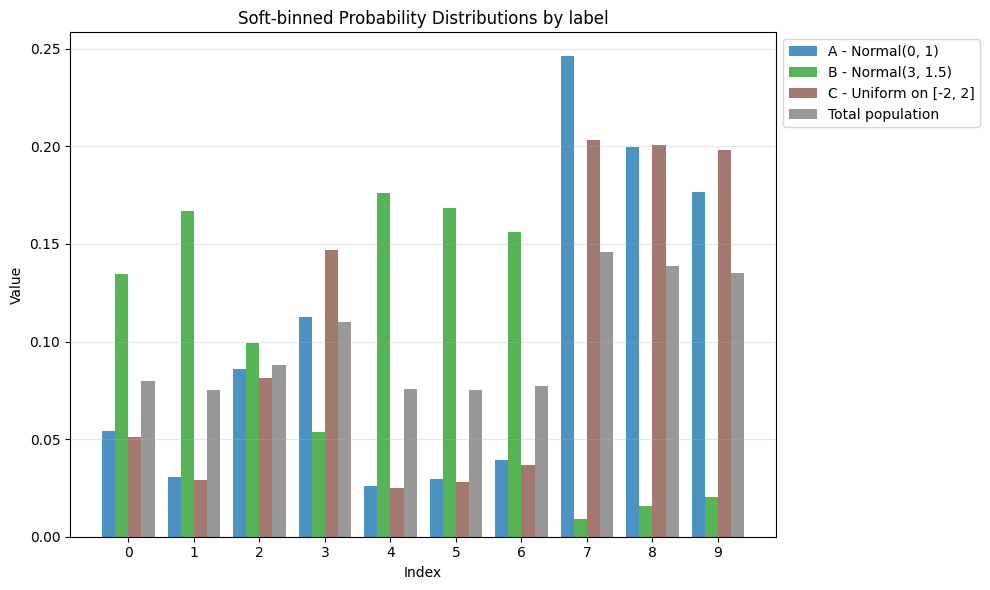

In [34]:
## Make the display tensor and labels
display_label_list = label_list + ['Total population']
display_tensor = torch.cat([prob_dist_by_label_tensor, prob_dist_for_total_population_tensor.unsqueeze(0)], dim=0)

## Plot the soft-binned probability distributions for each of the labels and also for the total population
plot_tensor_bars(display_tensor, title='Soft-binned Probability Distributions by label', 
                 separate_plots=False, labels=display_label_list)

## 4. Compute Entropy for each population label

In [35]:
## Compute the entropy for the total population
total_population_entropy = entropy(prob_dist_for_total_population_tensor)
total_population_entropy

tensor(2.2647, dtype=torch.float64)

In [36]:
## Compute the entropy for each label
entropy_by_label_tensor = entropy(prob_dist_by_label_tensor)
entropy_by_label_tensor

tensor([2.0201, 2.0380, 2.0207], dtype=torch.float64)

In [37]:
## Store the entropies in a dictionary for easy reference
entropy_dict = {
    'total_population': total_population_entropy.item()
}
for i, label in enumerate(label_list):
    entropy_dict[label] = entropy_by_label_tensor[i].item()

## Display the dictionary
entropy_dict

{'total_population': 2.264682438561093,
 'A - Normal(0, 1)': 2.020080840453379,
 'B - Normal(3, 1.5)': 2.0379819680237015,
 'C - Uniform on [-2, 2]': 2.020740352720607}

## 5. Compute the Conditional Entropy -- for the sample population $Z$ given its label $L$
**Note:** 
We compute the conditional entropies $H(Z|L)$,
where $Z$ is the total population and $L$ is the categorical label variable. 

We use the formula

$H(Z|L) = \sum_{l \in L} p(l) H(Z|L=l)$

where 

$H(Z|L=l) = -\sum_{z \in Z} p(z|l) \log p(z|l)$

Here we define
- $Z$ := Population data distribution (continuous vector-valued RV)
- $L$ := Sub-population label (categorical RV)

[https://en.wikipedia.org/wiki/Conditional_entropy](https://en.wikipedia.org/wiki/Conditional_entropy)

In [38]:
## Let's compute the conditional entropies for the population given the categorical label
conditional_entropy_of_population_given_the_label = torch.dot(distribution_of_labels, entropy_by_label_tensor).item()
conditional_entropy_of_population_given_the_label

2.0263776693898157

## 6. Compute Mutual Information between the total population RV and the label RV
By definition, the __mutual information__ ${\displaystyle \operatorname {I} (Z, L)}$ of the two random variables $Z$ and $L$ is given by

${\displaystyle \operatorname {I} (Z, L) := \mathrm {H} (Z) - \mathrm {H} (Z|L)\,}$

and we define 
- $Z$ := Population data distribution (continuous vector-valued RV)
- $L$ := Sub-population label (categorical RV)

In [39]:
## Check: This is non-negative -- as it's supposed to be!
mutual_information = entropy_dict['total_population'] - conditional_entropy_of_population_given_the_label
mutual_information

0.2383047691712772

### Entropy Summmary:

In [40]:
entropy_dict['total_population']

2.264682438561093

In [41]:
conditional_entropy_of_population_given_the_label

2.0263776693898157

In [42]:
mutual_information

0.2383047691712772